In [1]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import root_mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import optuna
import numpy as np
from dataset import Dataset
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import shap

seed = 1234
sns.set_theme(style="white")

/usr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: type 'Series' is not subscriptable

In [28]:
# Data
dataset = Dataset('spinning_data.hf5')
dataset = Dataset('spinning_data_embeddings.hf5')
scaler = MinMaxScaler()
dataset.df.iloc[:,-5:] = scaler.fit_transform(dataset.targets)
#dataset.df.drop('Protein', axis=1)

df_train, df_test = train_test_split(dataset.df, test_size=.15, shuffle=True, random_state=seed)
ds = {}
ds['train'] = Dataset(df_train)
ds['test'] = Dataset(df_test)

X = {}
Y = {}
X['train'], Y['train'] = ds['train']()
X['test'], Y['test'] = ds['test']()
#Y['train'].iloc[:] = scaler.transform(Y['train'])
#Y['test'].iloc[:] = scaler.transform(Y['test'])

In [30]:
print(X['train'].columns)

Index(['Protein', 'concentration (mg/ml)', 'Spinning device',
       'Extrusion device', 'Number of baths', 'Temperature SB',
       'Spinning Buffer', 'SB pH', 'SB conc. (mM)', 'NaCl (mM)',
       'Capillery type', 'Capillery size (um)', 'Reeling speed (rpm)',
       'Flow rate (ul/min)', 'pumppressure (bar)', 'Temp C (spinning)',
       'Humidity (spinning)', 'Continous spinning', 'pca_1', 'pca_2', 'pca_3',
       'pca_4', 'pca_5', 'pca_6', 'pca_7', 'pca_8', 'pca_9', 'pca_10',
       'pca_11', 'pca_12', 'pca_13', 'pca_14', 'pca_15'],
      dtype='object')


In [12]:
def objective(trial):
    kf = KFold(n_splits=5, shuffle=True, random_state=seed)
    fixed_max_iter = 1000

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_leaf_nodes": trial.suggest_categorical("max_leaf_nodes", [15, 31, 63, 127]),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 20),
        "l2_regularization": trial.suggest_float("l2_regularization", 0.0, 10.0),
        "early_stopping": True,
        "validation_fraction": 0.1,  # Let sklearn split off 10% internally
        "n_iter_no_change": 10,
        "max_iter": fixed_max_iter,
        "categorical_features": ds['train'].categorical_features,
        "loss": "squared_error"
    }

    model = MultiOutputRegressor(HistGradientBoostingRegressor(**params))

    cv_rmse = []
    for train_idx, val_idx in kf.split(X['train']):
        X_train, X_val = X['train'].iloc[train_idx], X['train'].iloc[val_idx]
        Y_train, Y_val = Y['train'].iloc[train_idx], Y['train'].iloc[val_idx]

        model.fit(X_train, Y_train)  # internal early stopping on 10% of X_train
        preds = model.predict(X_val)
        rmse = root_mean_squared_error(Y_val, preds)
        cv_rmse.append(rmse)

    return np.mean(cv_rmse)

In [31]:
# Run Optuna
study = optuna.create_study(direction="minimize", study_name='K-fold')
study.optimize(objective, n_trials=50, timeout=1800)

# Output results
print("Best RMSE:", study.best_value)
print("Best hyperparameters:")
for k, v in study.best_params.items():
    print(f"  {k}: {v}")

[I 2025-05-20 19:37:59,837] A new study created in memory with name: K-fold


NameError: name 'objective' is not defined

In [32]:
params = {
    "learning_rate": 0.13295232895824177,
    "max_leaf_nodes": 31,
    "min_samples_leaf": 2,
    "l2_regularization": 9.000826977751071,
    "early_stopping": False,
    "n_iter_no_change": 10,
    "max_iter": 200,
    "categorical_features": ds['train'].categorical_columns,
    "loss": "squared_error"
}

'''
params = {
    "early_stopping": False,
    "n_iter_no_change": 10,
    "max_iter": 200,
    "categorical_features": ds_train.categorical_features,
    #"verbose": 1
} | study.best_params
'''
model = MultiOutputRegressor(HistGradientBoostingRegressor(**params))
model.fit(X['train'], Y['train'])

MultiOutputRegressor(estimator=HistGradientBoostingRegressor(categorical_features=['Protein',
                                                                                   'Spinning '
                                                                                   'device',
                                                                                   'Extrusion '
                                                                                   'device',
                                                                                   'Number '
                                                                                   'of '
                                                                                   'baths',
                                                                                   'Spinning '
                                                                                   'Buffer',
                                                                                   'Capillery '
                                                                                   'type',
                                                                                   'Continous '
                                                                                   'spinning'],
                                                             early_stopping=False,
                                                             l2_regularization=9.000826977751071,
                                                             learning_rate=0.13295232895824177,
                                                             max_iter=200,
                                                             min_samples_leaf=2))

In [33]:
preds = {}
preds['train'] = pd.DataFrame(model.predict(X['train']), columns=Y['train'].columns)
preds['test'] = pd.DataFrame(model.predict(X['test']), columns=Y['test'].columns)

metrics = {}
for k in ['train', 'test']:
    metrics[k] = pd.DataFrame(columns=Y[k].columns)
    metrics[k].loc['R2', :] = r2_score(Y[k], preds[k], multioutput='raw_values')
    metrics[k].loc['RMSE', :] = root_mean_squared_error(Y[k], preds[k], multioutput='raw_values')
    metrics[k].loc['MAE', :] = mean_absolute_error(Y[k], preds[k], multioutput='raw_values')

In [34]:

for k in ['train', 'test']:
    buf = metrics[k].rename({'R2':r'$R^2$'}).\
        to_latex(caption=f'Metrics for {k} set.', label='tab:metrics')
    print(buf)

\begin{table}
\caption{Metrics for train set.}
\label{tab:metrics}
\begin{tabular}{llllll}
\toprule
 & Diameter (µm) & strain (mm/mm) & strength (MPa) & Youngs Modulus (Gpa) & Toughness (MJ m-3) \\
\midrule
$R^2$ & 0.691778 & 0.679487 & 0.557286 & 0.369968 & 0.502307 \\
RMSE & 0.065387 & 0.141887 & 0.091891 & 0.059968 & 0.124158 \\
MAE & 0.039158 & 0.092295 & 0.061345 & 0.041814 & 0.084222 \\
\bottomrule
\end{tabular}
\end{table}

\begin{table}
\caption{Metrics for test set.}
\label{tab:metrics}
\begin{tabular}{llllll}
\toprule
 & Diameter (µm) & strain (mm/mm) & strength (MPa) & Youngs Modulus (Gpa) & Toughness (MJ m-3) \\
\midrule
$R^2$ & 0.301525 & 0.668577 & 0.363481 & -1.281667 & 0.430851 \\
RMSE & 0.163481 & 0.155394 & 0.097170 & 0.235855 & 0.150541 \\
MAE & 0.110490 & 0.102888 & 0.064131 & 0.197704 & 0.103905 \\
\bottomrule
\end{tabular}
\end{table}



In [35]:
for k in ['train', 'test']:
    metrics[k].to_html(f'../figures/metrics_{k}.html')

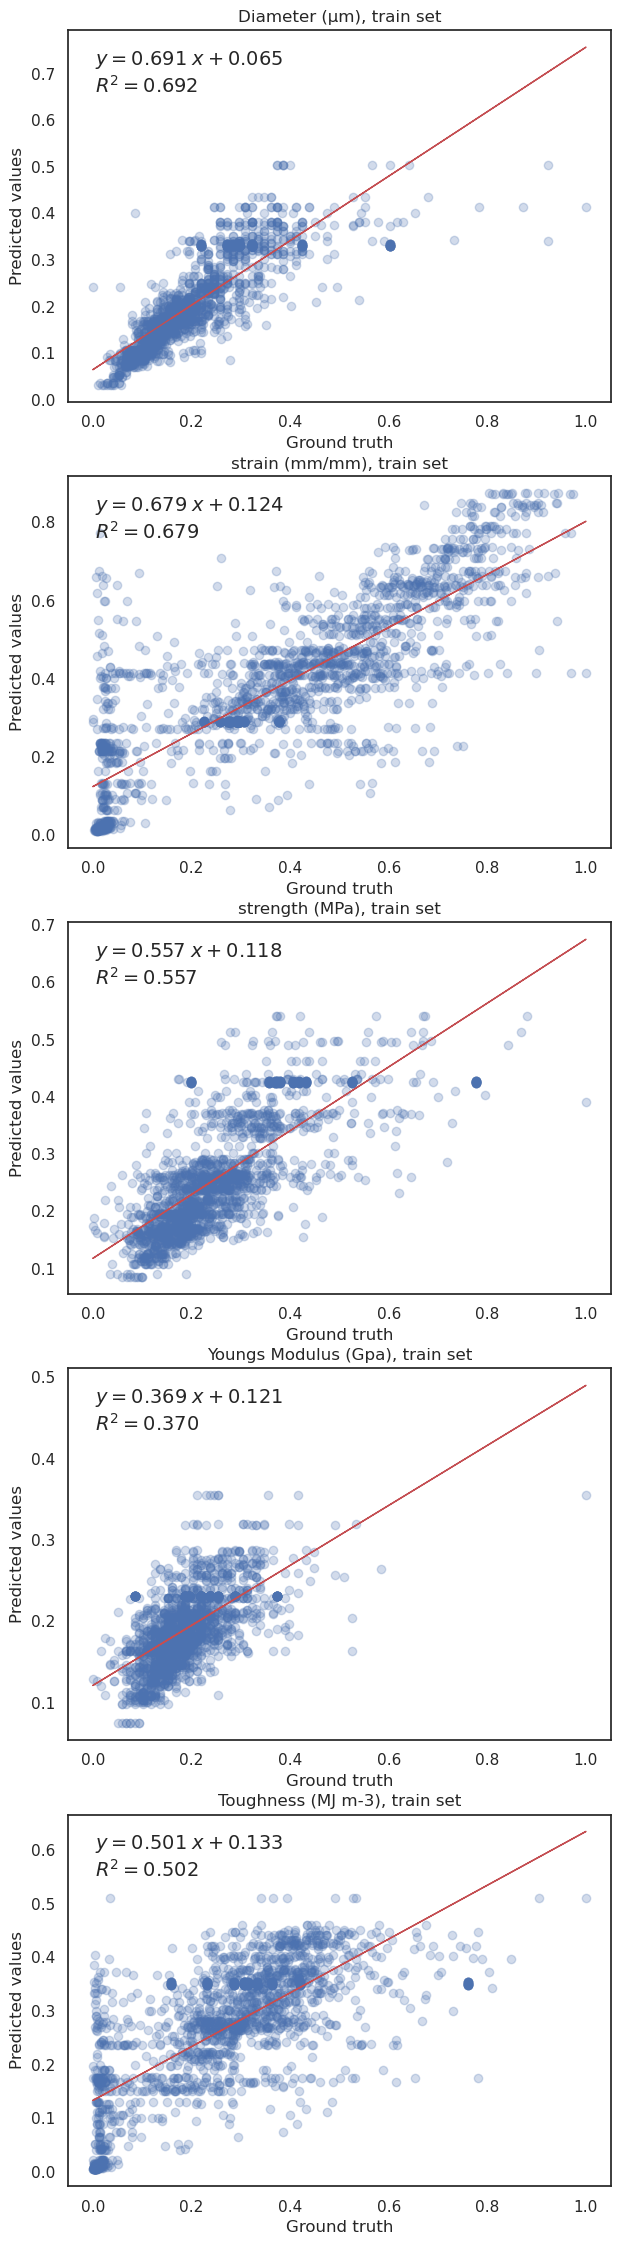

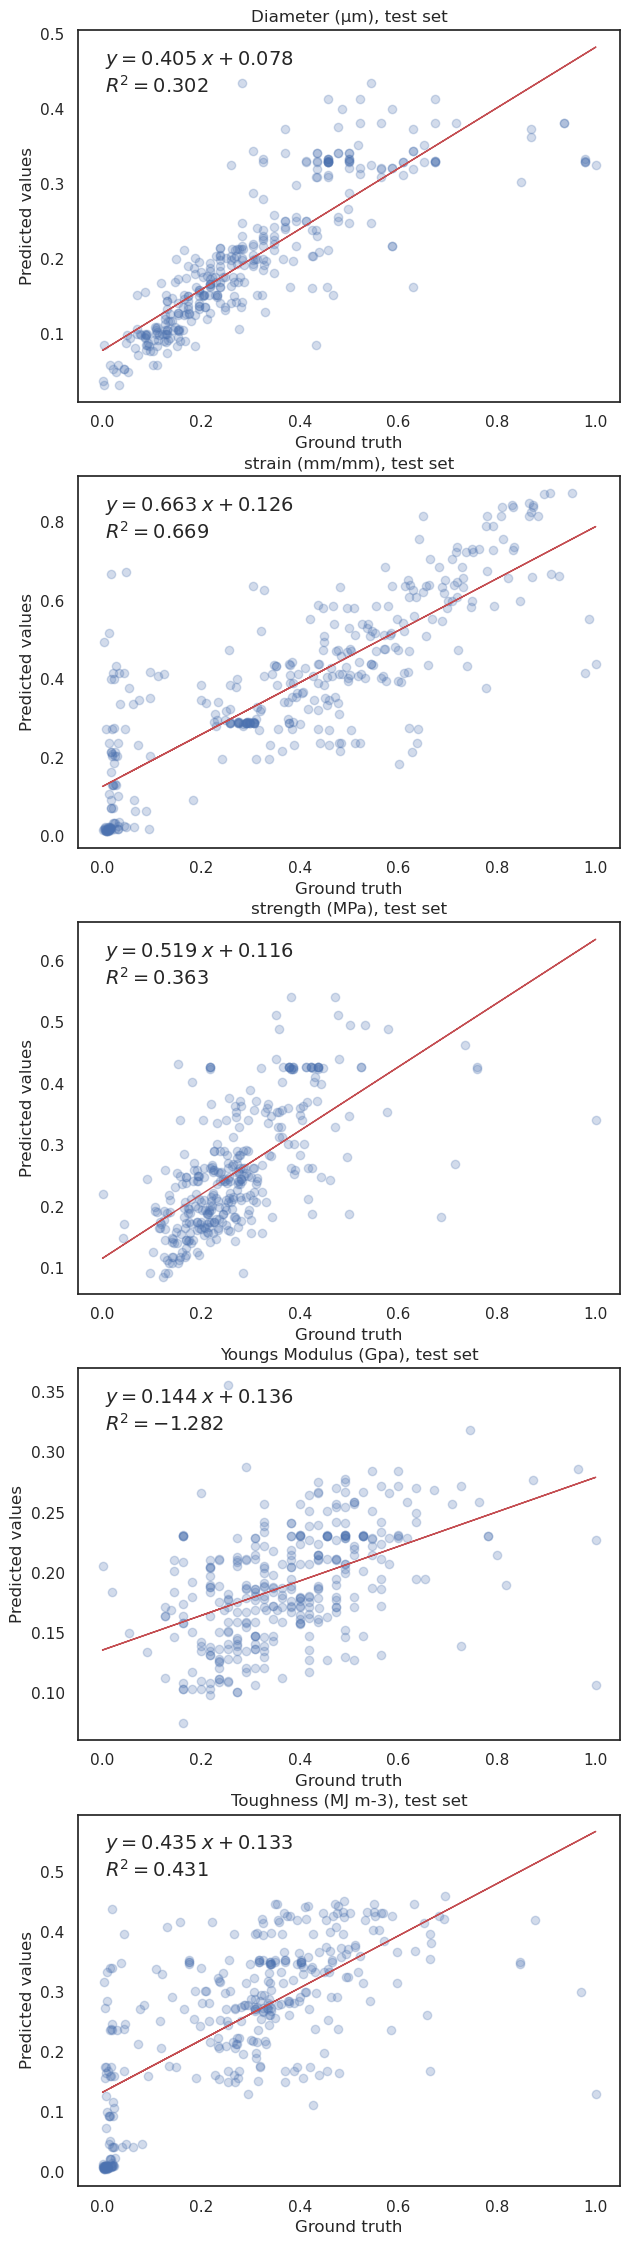

In [36]:
for k in ['train', 'test']:
    fig, axs = plt.subplots(5, 1)
    fig.set_figheight(28)
    fig.set_figwidth(7)
    for i in range(5):
        col = Y[k].columns[i]
        x = Y[k].iloc[:,i].astype('float').to_numpy()
        y = preds[k].iloc[:,i].astype('float').to_numpy()
        z = np.polyfit(x, y, 1)
        y_hat = np.poly1d(z)(x)
        axs[i].set_title(f'{col}, {k} set')
        axs[i].set_xlabel('Ground truth')
        axs[i].set_ylabel('Predicted values')
        axs[i].scatter(x, y, c='b', alpha=.25)
        axs[i].plot(x, y_hat, "r-", lw=1)
        text = r"$y={:0.3f}\;x+{:0.3f}$".format(z[0], z[1]) + "\n" + r"$R^2 = {:0.3f}$".format(metrics[k].loc['R2', col])
        axs[i].text(0.05, 0.95, text, transform=axs[i].transAxes,
        fontsize=14, verticalalignment='top')
        #plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
        # fontsize=14, verticalalignment='top')
        #plt.axis('scaled')
        #plt.axis('square')
    fig.savefig(f'../figures/scatter_{k}.png')
    plt.show()

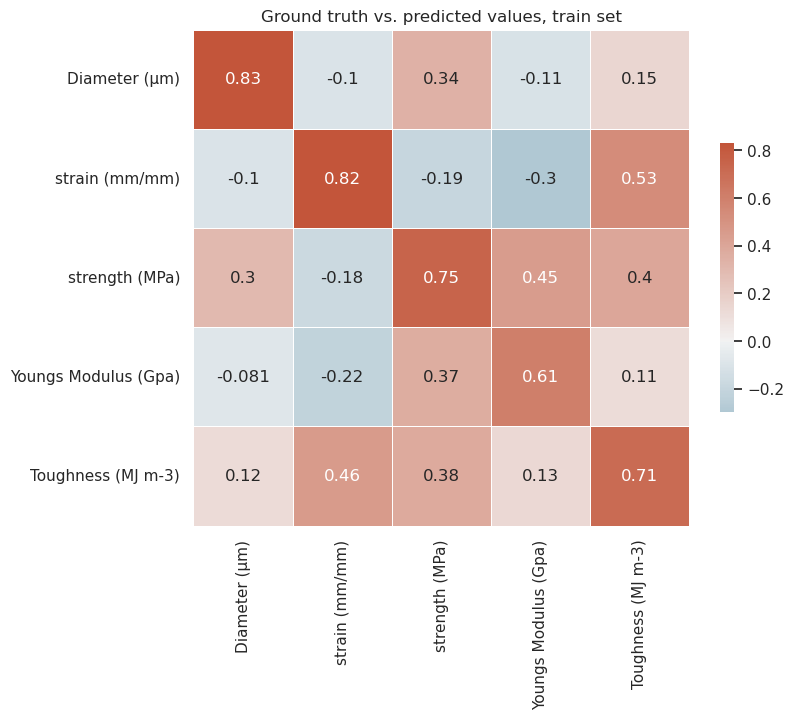

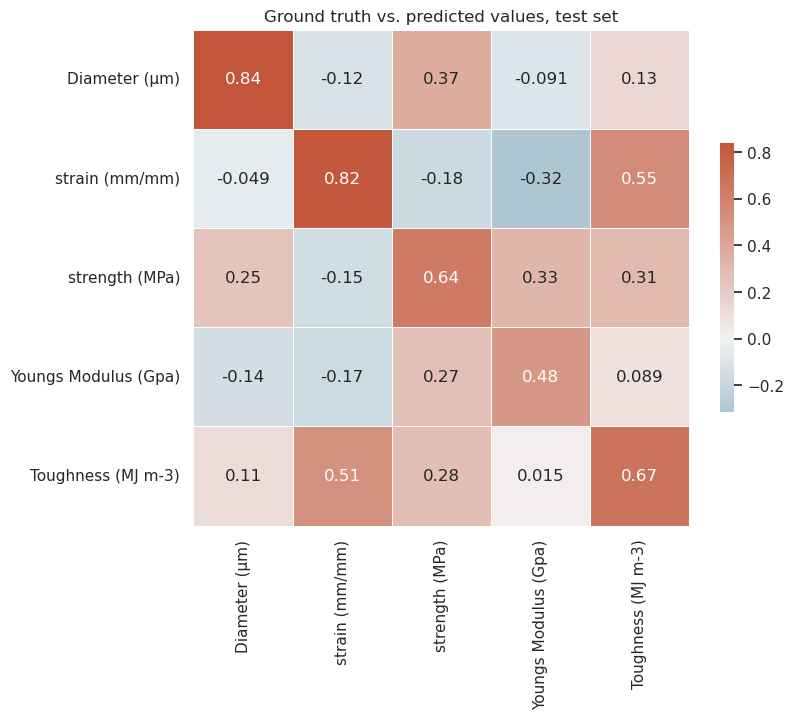

In [37]:
for k in ['train', 'test']:
    fig, ax = plt.subplots(figsize=(8, 7))
    ax.set_title(f'{'Ground truth vs. predicted values'}, {k} set')
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    corr = pd.DataFrame()
    for col in Y[k].columns:
        corr[col] = Y[k].corrwith(preds[k][col], method='pearson')
    sns.heatmap(corr, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, cmap=cmap, annot=True)
    fig.savefig(f'../figures/pearson_{k}.png', bbox_inches='tight')
    plt.show()

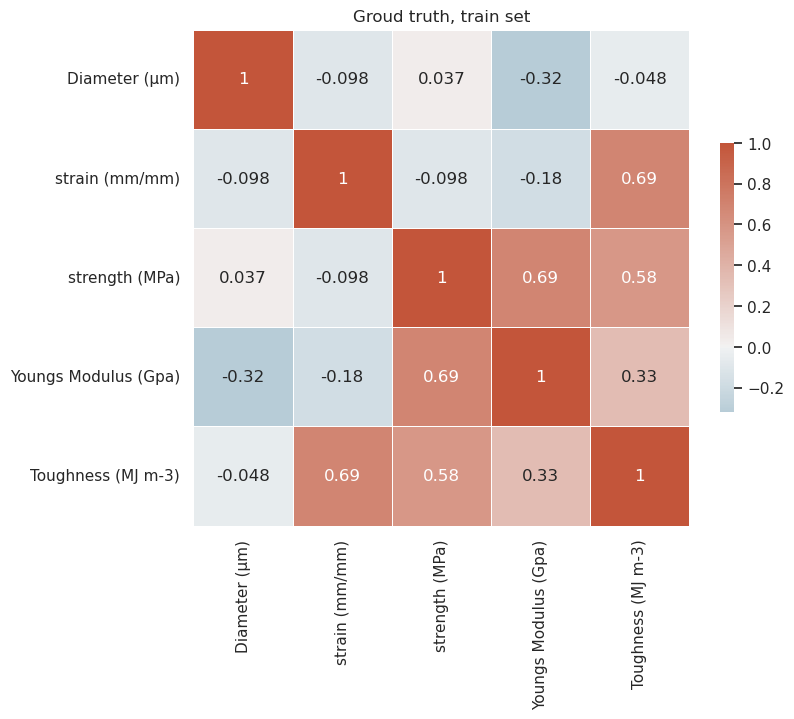

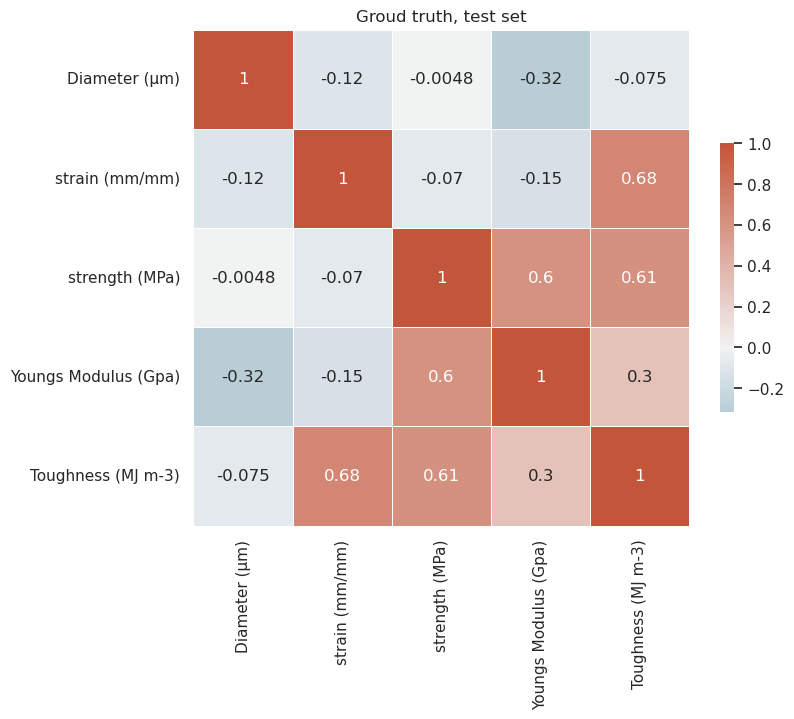

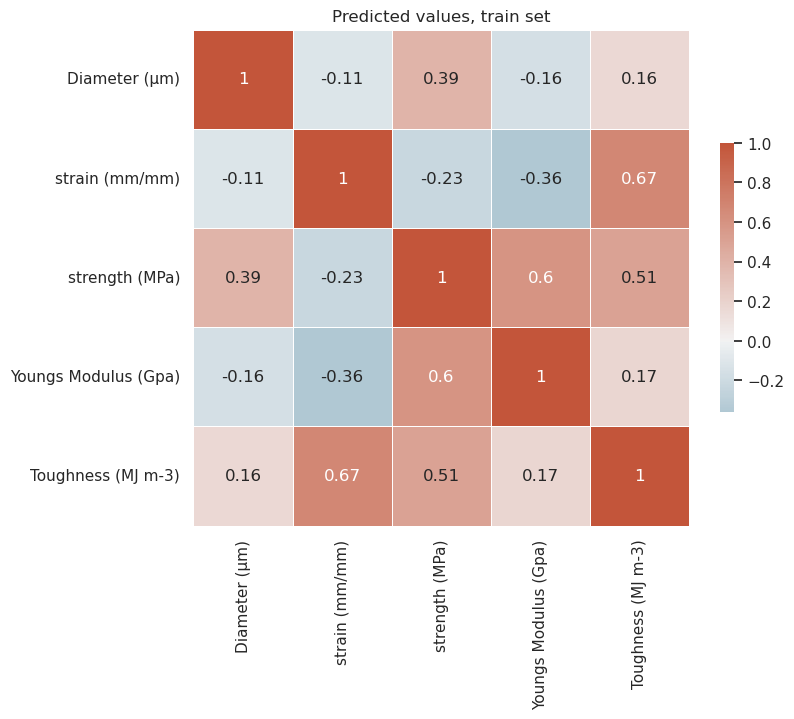

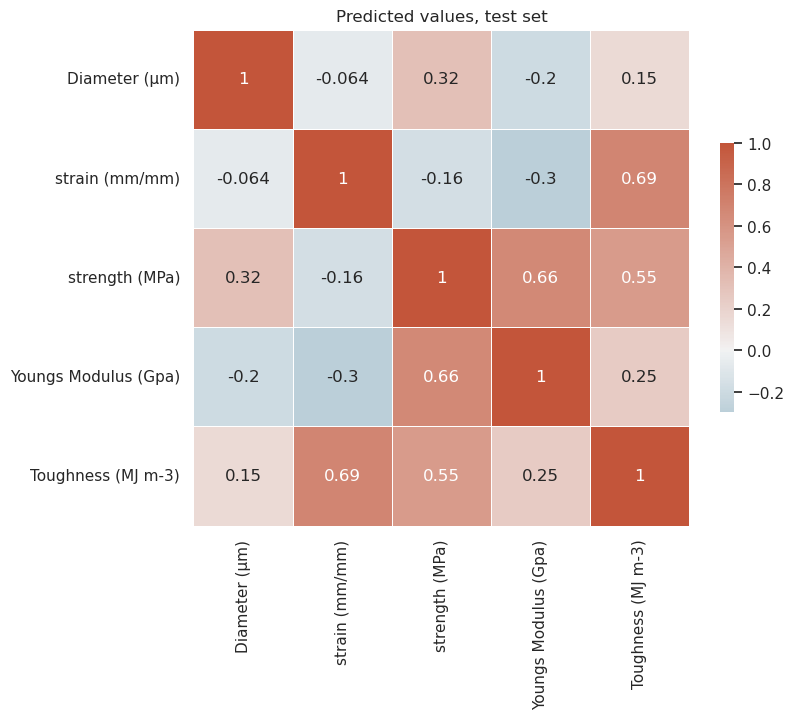

In [77]:
for Ys in [Y, preds]:
    for k in ['train', 'test']:
        fig, ax = plt.subplots(figsize=(8, 7))
        ax.set_title(f'{'Groud truth' if Ys is Y else 'Predicted values'}, {k} set')
        cmap = sns.diverging_palette(230, 20, as_cmap=True)
        sns.heatmap(Ys[k].corr(method='pearson'), center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, cmap=cmap, annot=True)
        fig.savefig(f'../figures/pearson_{'truth' if Ys is Y else 'pred'}_{k}.png', bbox_inches='tight')
        plt.show()

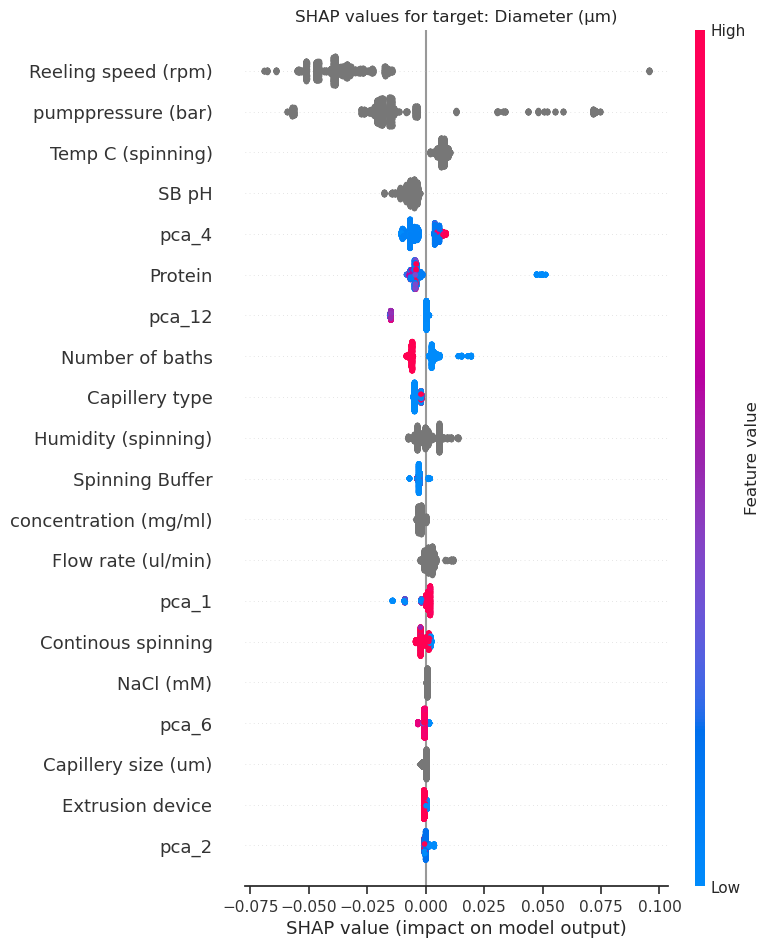

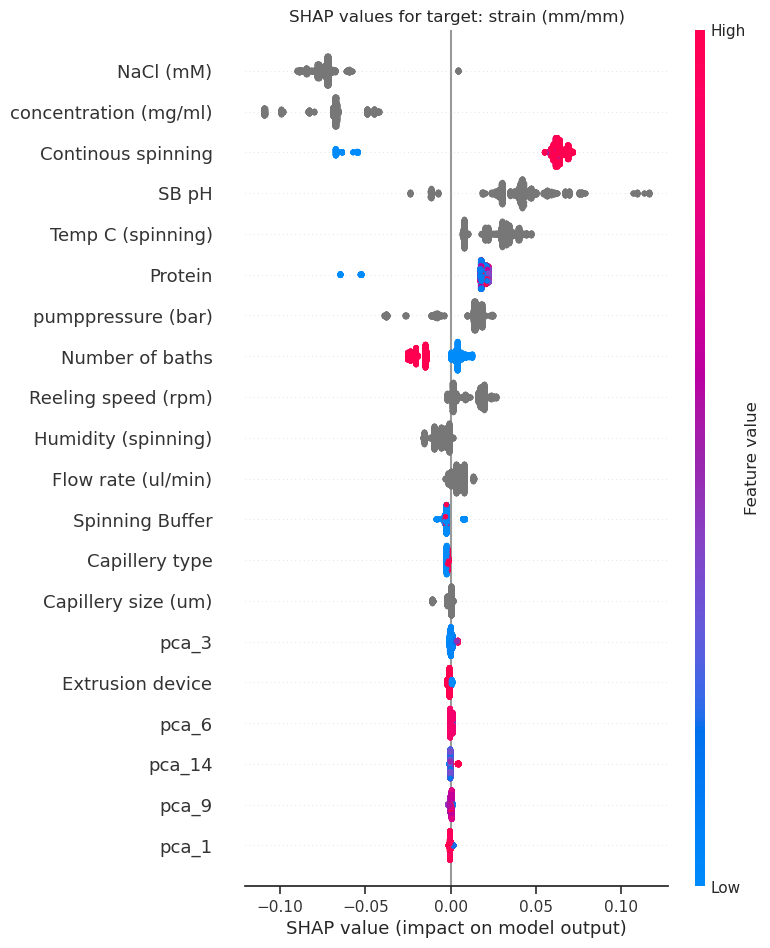

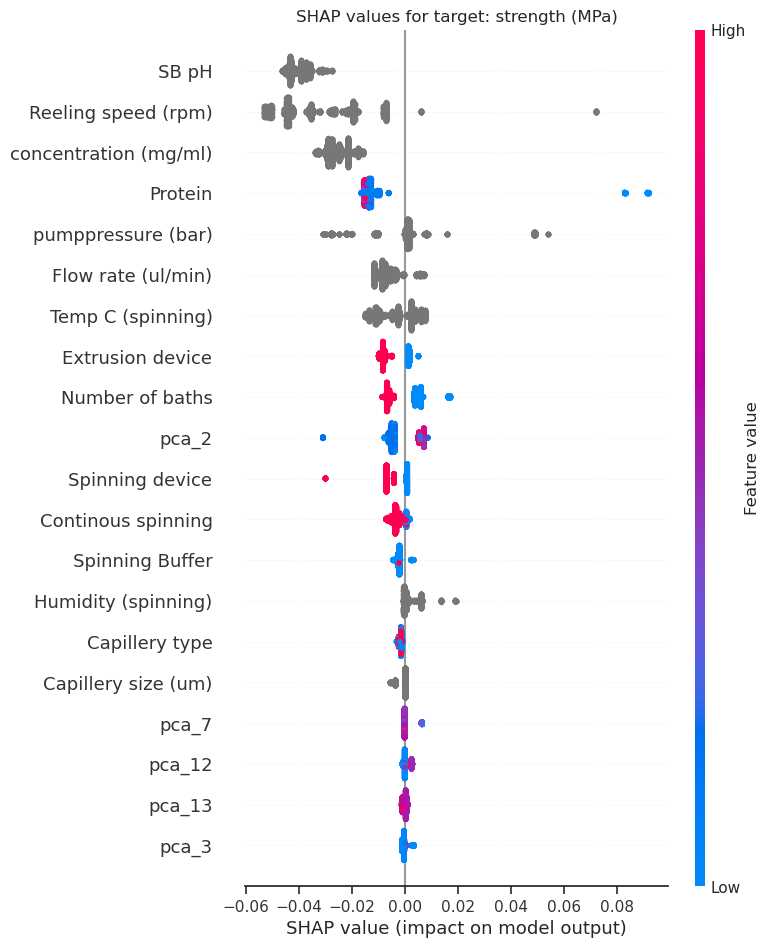

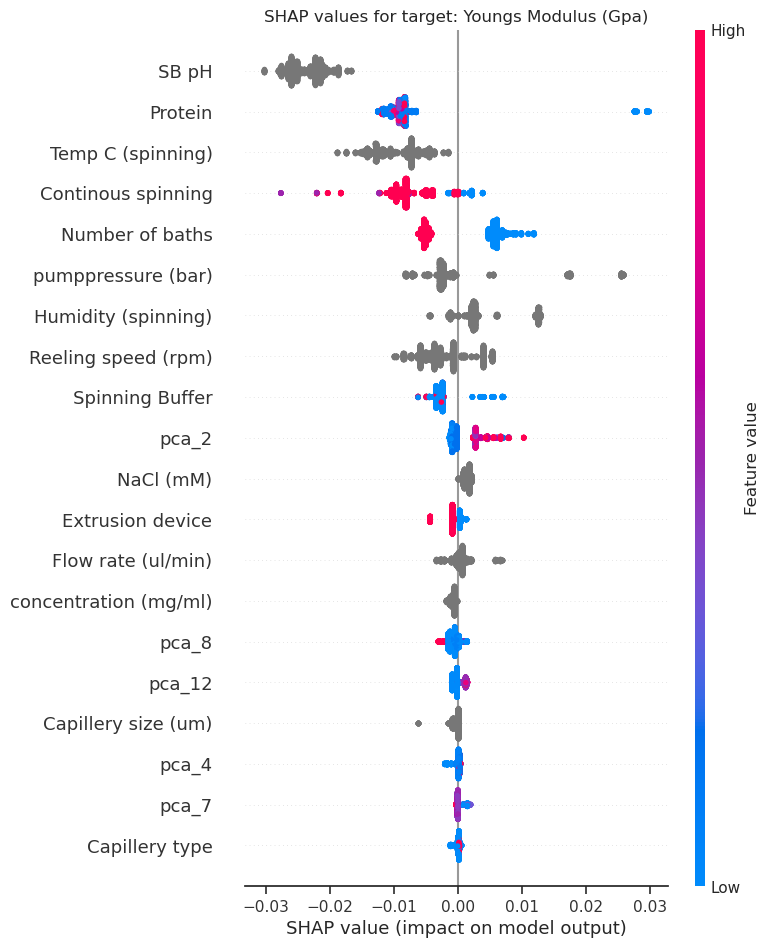

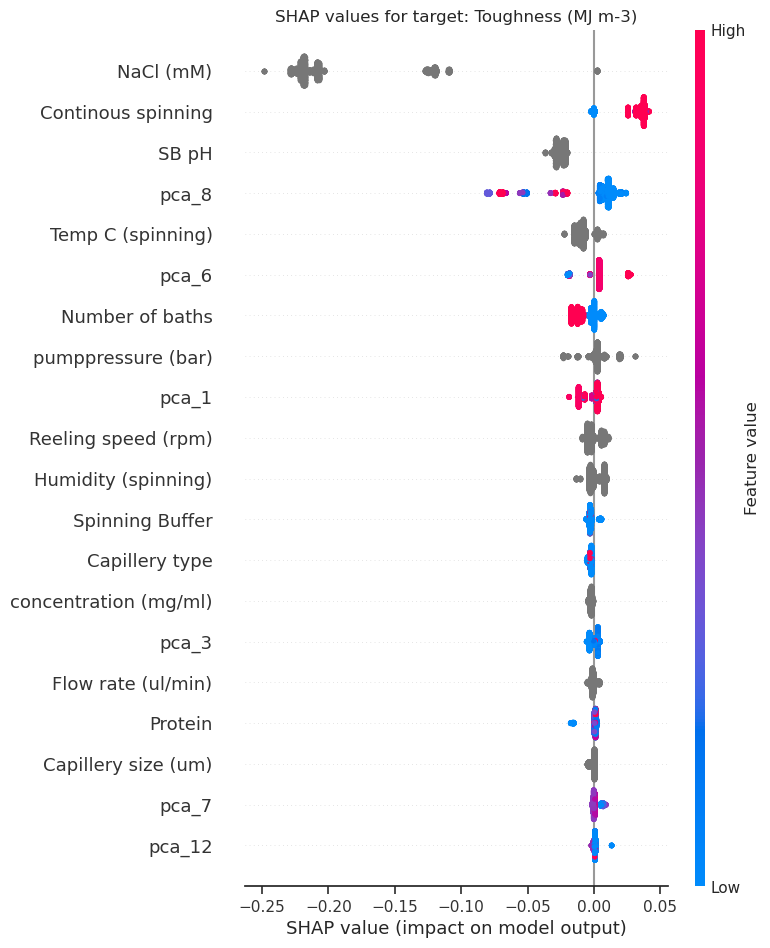

In [39]:
# Your trained MultiOutputRegressor model
multi_model = model  # MultiOutputRegressor(HistGradientBoostingRegressor(...))
X_sample = dataset.features # Or a subset like X_train[:200] for faster results

# Copy your input dataframe
X_encoded = X_sample.copy()

# Convert your categorical columns to 'category' dtype
for col in dataset.categorical_columns:  # list of your categorical column names
    X_encoded[col] = X_encoded[col].astype("category")
    X_encoded[col] = X_encoded[col].cat.codes  # convert to integer codes

# Loop over each target output
for i, estimator in enumerate(multi_model.estimators_):
    #print(f"\n🔹 SHAP values for target: {dataset.columns[-5+i]}")
    
    # Create a SHAP explainer (TreeExplainer is efficient for gradient boosting models)
    explainer = shap.Explainer(estimator)
    
    # Compute SHAP values for the input data
    shap_values = explainer(X_encoded)
    
    # Plot summary plot
    shap.summary_plot(shap_values, features=X_encoded, feature_names=X_encoded.columns, show=False)
    plt.title(f"SHAP values for target: {dataset.columns[-5+i]}")
    plt.show()

In [7]:
# Assume `y_dict` is a dict with sample names as keys, and a (10 x 5) array of floats as values
df_means = pd.DataFrame()
df_stds = pd.DataFrame()
df_cvs = pd.DataFrame()


df = dataset.group_samples()

for i in range(len(df)):
    sample = df.at[i, 'Sample number']
    df_means.at[i, 'Sample number'] = sample
    df_stds.at[i, 'Sample number'] = sample
    df_cvs.at[i, 'Sample number'] = sample
    for col in df.iloc[:,-5:].columns:
        df_means.at[i, col] = np.mean(df.at[i, col])
        df_stds.at[i, col] = np.std(df.at[i, col])
        df_cvs.at[i, col] = df_stds.at[i, col] / df_means.at[i, col]
    #noise_df.loc[sample, 'mean'] = 
    #    "mean": me,
    #    "std": stds,
    #    "cv": stds / means  # Coefficient of variation (unitless)
    #}

In [11]:
print(df_stds.to_numpy().shape)

(204, 6)


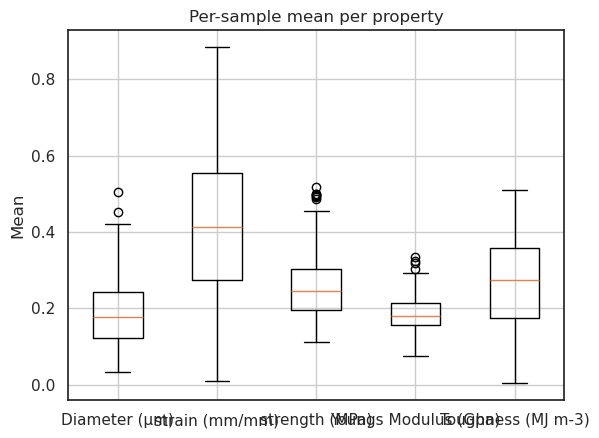

In [14]:
plt.boxplot(df_means.iloc[:,1:], tick_labels=dataset.targets.columns)
plt.title("Per-sample mean per property")
plt.ylabel("Mean")
plt.grid(True)
plt.show()

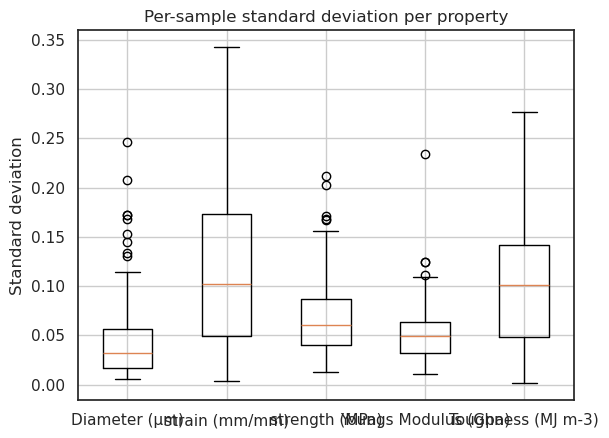

In [13]:
plt.boxplot(df_stds.iloc[:,1:], tick_labels=dataset.targets.columns)
plt.title("Per-sample standard deviation per property")
plt.ylabel("Standard deviation")
plt.grid(True)
plt.show()

In [26]:
# Outlier
print(Dataset().df.loc[dataset.df['Youngs Modulus (Gpa)']==1.0, :].to_string())

    Sample number    Protein  concentration (mg/ml) Spinning device Extrusion device Number of baths  Temperature SB Spinning Buffer  SB pH  SB conc. (mM)  NaCl (mM) Capillery type Capillery size (um) Reeling speed (rpm) Flow rate (ul/min) pumppressure (bar) Temp C (spinning)  Humidity (spinning) Continous spinning Diameter (µm) strain (mm/mm) strength (MPa) Youngs Modulus (Gpa) Toughness (MJ m-3)
463            50  Rep7 Tusp                  400.0            Hulk     Syringe pump               1            22.0   Succinate (K)    5.0          500.0        0.0          Glass                70.0                50.0               17.0                NaN              22.1                  0.1                yes          9.16        0.07743      89.970753                 12.0           3.612944


In [28]:
print(df_stds.to_string())

    Sample number  Diameter (µm)  strain (mm/mm)  strength (MPa)  Youngs Modulus (Gpa)  Toughness (MJ m-3)
0              10       0.021836        0.334063        0.050236              0.051577            0.219684
1              11       0.010958        0.103354        0.050440              0.040297            0.090582
2              12       0.013274        0.099548        0.084646              0.055964            0.122912
3              13       0.024612        0.027609        0.100638              0.070645            0.013215
4              14       0.017986        0.157050        0.083776              0.088999            0.122500
5              15       0.047240        0.104979        0.049318              0.064896            0.083150
6              16       0.011659        0.100896        0.066446              0.049964            0.051025
7              17       0.037726        0.003839        0.051033              0.040607            0.002972
8              18       0.018074     